In [ ]:
# !pip install opencv-python

In [68]:
import os
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split, ConcatDataset
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
import cv2


In [54]:
def show_tensor_image(tensor):  # 텐서 순서를 (C, H, W)에서 (H, W, C)로 변경하고 numpy array로 변환
    image = tensor.permute(1, 2, 0).numpy()
    plt.imshow(image)
    plt.axis('off')
    plt.show()

In [55]:
def val_plot(train_losses, test_losses, train_accuracies, test_accuracies):
    fig, axs = plt.subplots(2, 1, figsize=(10, 10))

    axs[0].plot(train_losses, label='Training Loss')
    axs[0].plot(test_losses, label='Test Loss')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Loss')
    axs[0].legend()
    axs[0].set_title('Training and Test Loss')

    axs[1].plot(train_accuracies, label='Training Accuracy')
    axs[1].plot(test_accuracies, label='Test Accuracy')  # , color='orange'
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Accuracy (%)')
    axs[1].legend()
    axs[1].set_title('Training and Test Accuracy')

    plt.tight_layout()
    plt.show()

In [56]:
def cuda_message():
    if torch.cuda.is_available():
        print("CUDA(GPU)를 사용합니다.")
    else:
        print("CUDA(GPU)를 사용할 수 없으므로, CPU를 사용합니다.")

In [57]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

cuda_message()

CUDA(GPU)를 사용합니다.


In [58]:
# myResNet 클래스 정의
class myResNet(nn.Module):
    def __init__(self, model_num=18, num_classes=2):
        super(myResNet, self).__init__()

        if model_num == 18:
            self.resnet = models.resnet18(weights=None)
        elif model_num == 34:
            self.resnet = models.resnet34(weights=None)
        elif model_num == 50:
            self.resnet = models.resnet50(weights=None)
        elif model_num == 101:
            self.resnet = models.resnet101(weights=None)
        elif model_num == 152:
            self.resnet = models.resnet152(weights=None)

        # 출력 레이어를 클래스 수에 맞게 조정
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        return self.resnet(x)

In [59]:
# myVGG 클래스 정의
class myVGG(nn.Module):
    def __init__(self, model_kind="16", num_classes=2):
        super(myVGG, self).__init__()

        if model_kind == "11":
            self.vgg = models.vgg11(weights=None)
        elif model_kind == "11_bn":
            self.vgg = models.vgg11_bn(weights=None)
        elif model_kind == "13":
            self.vgg = models.vgg13(weights=None)
        elif model_kind == "13_bn":
            self.vgg = models.vgg13_bn(weights=None)
        elif model_kind == "16":
            self.vgg = models.vgg16(weights=None)
        elif model_kind == "16_bn":
            self.vgg = models.vgg16_bn(weights=None)
        elif model_kind == "19":
            self.vgg = models.vgg19(weights=None)
        elif model_kind == "19_bn":
            self.vgg = models.vgg19_bn(weights=None)

        # 출력 레이어를 클래스 수에 맞게 조정
        num_ftrs = self.vgg.classifier[6].in_features  # classifier["6"] -> 6, vgg에서 정해진 수?
        self.vgg.classifier[6] = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        return self.vgg(x)

In [60]:
# myLeNet 클래스 정의
class myLeNet(nn.Module):
    def __init__(self, num_classes=2):
        super(myLeNet, self).__init__()
        self.lenet = models.googlenet(weights=None)

        # 출력 레이어를 클래스 수에 맞게 조정
        num_ftrs = self.lenet.fc.in_features
        self.lenet.fc = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        return self.lenet(x)

In [61]:
def train(model, train_loader, optimizer, epoch):
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    for data, target in train_loader:
        if torch.cuda.is_available():
            data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        train_loss += loss.item()  # 어차피 train에선 test와 달리 loss.backward() 해야하기 때문에 loss 따로 객체화
        loss.backward()
        optimizer.step()
    # 예측값 계산 (가장 높은 값을 가진 인덱스)
    _, predicted = torch.max(output.data, 1)  # output.argmax(dim=1, keepdim=True)
    total += target.size(0)
    # 올바르게 예측된 샘플의 수 업데이트
    correct += (predicted == target).sum().item()  # pred.eq(target.view_as(pred)).sum().item()
    # 평균 훈련 손실 계산
    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    accuracy = 100. * correct / total
    train_accuracies.append(accuracy)
    print(f'Epoch {epoch}, Training loss: {train_loss:.4f}, Accuracy: {accuracy:.2f}%')

In [62]:
def test(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            if torch.cuda.is_available():
                data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            # .view_as(): View this tensor as the same size as other. self.view_as(other) is equivalent to self.view(other.size())
    test_loss /= len(test_loader)
    accuracy = 100. * correct / len(test_loader.dataset)
    test_losses.append(test_loss)
    test_accuracies.append(accuracy)
    print(f'Test loss: {test_loss:.4f}, Accuracy: {accuracy:.2f}%')

In [63]:
def calculate_norm(dataset):
    # dataset의 axis=1, 2에 대한 평균 산출
    mean_ = np.array([np.mean(x.numpy(), axis=(1, 2)) for x, _ in dataset])
    # r, g, b 채널에 대한 각각의 평균 산출
    mean_r = mean_[:, 0].mean()
    mean_g = mean_[:, 1].mean()
    mean_b = mean_[:, 2].mean()
    # dataset의 axis=1, 2에 대한 표준편차 산출
    std_ = np.array([np.std(x.numpy(), axis=(1, 2)) for x, _ in dataset])
    # r, g, b 채널에 대한 각각의 표준편차 산출
    std_r = std_[:, 0].mean()
    std_g = std_[:, 1].mean()
    std_b = std_[:, 2].mean()

    return (mean_r, mean_g, mean_b), (std_r, std_g, std_b)

In [64]:
# import shutil
# shutil.rmtree('C:/Users/bgmbg/Downloads/face_age/.ipynb_checkpoints')

In [65]:
trans_origin = transforms.Compose(
    [
        # transforms.CenterCrop((500, 500)),  # norm 계산 여부
        transforms.ToTensor(),
    ]
)

# 아래 수정/출력 요망

# full_dataset = datasets.ImageFolder(root='./face_age', transform=transform)
# test_dataset_origin = ImageFolder('IMAGE/Covid19-dataset/test', transform=trans_origin)
# test_loader_origin = torch.utils.data.DataLoader(test_dataset_origin, batch_size=64, shuffle=False)

# original_images, _ = next(iter(test_loader_origin))
# transform_images, _ = next(iter(test_loader))

# fig, axes = plt.subplots(3, 3)
# fig.set_size_inches(4, 6)

# for idx in range(3):
#     axes[idx, 0].imshow(original_images[idx].permute(1, 2, 0), cmap='gray')
#     axes[idx, 0].set_axis_off()
#     axes[idx, 0].set_title('Original (200,200)')
#     axes[idx, 1].imshow(transform_images[idx].permute(1, 2, 0), cmap='gray')
#     axes[idx, 1].set_axis_off()
#     axes[idx, 1].set_title('Resized (100,100)')
#     axes[idx, 2].imshow(transform_images[idx].permute(1, 2, 0), cmap='gray')
#     axes[idx, 2].set_axis_off()
#     axes[idx, 2].set_title('Resized (50,50)')
# fig.tight_layout()
# plt.show()

In [69]:
# 데이터 증강! (500sets 이하 애들만 2배 뻥튀기)

# 입력 이미지 디렉토리
input_dir = "C:/Users/bgmbg/Downloads/face_age"

# 출력 이미지 디렉토리
output_dir = "C:/Users/bgmbg/Downloads/face_age"
os.makedirs(output_dir, exist_ok=True)

aug_needed = ["/10-12", "/13-15", "/30-34", "/40-44", "/45-49", "/55-59", "/60-64", "/65-69"]

# 각 디렉토리를 돌면서 이미지 증강 및 저장
for category_dir in aug_needed:
    category_path = input_dir + '' + category_dir
    print(input_dir)
    print(category_path)
    if os.path.isdir(category_path):
        category_output_dir = output_dir + '' + category_dir
        print(category_output_dir)
        os.makedirs(category_output_dir, exist_ok=True)
        
        # 이미지를 순회하면서 증강 및 저장
        for filename in os.listdir(category_path):
            print(filename)
            if filename.endswith(".jpg") or filename.endswith(".png"):
                img_path = category_path + '/' + filename
                print(img_path)
                # 이미지 불러오기
                img_plus = cv2.imread(img_path)
                img_plus = cv2.cvtColor(img_plus, cv2.COLOR_BGR2RGB)  # OpenCV는 BGR로 읽어옴.  # , cv2.COLOR_BGR2RGB
                
                # 이미지 증강
                img_flip_lr = cv2.flip(img_plus,1)
                
                # 증강된 이미지 저장
                cv2.imwrite(category_output_dir + '/' + f"{filename}_flip_lr.jpg", cv2.cvtColor(img_flip_lr, cv2.COLOR_RGB2BGR))

C:/Users/bgmbg/Downloads/face_age
C:/Users/bgmbg/Downloads/face_age/10-12
C:/Users/bgmbg/Downloads/face_age/10-12
1016.png
C:/Users/bgmbg/Downloads/face_age/10-12/1016.png
1022.png
C:/Users/bgmbg/Downloads/face_age/10-12/1022.png
1023.png
C:/Users/bgmbg/Downloads/face_age/10-12/1023.png
1064.png
C:/Users/bgmbg/Downloads/face_age/10-12/1064.png
1069.png
C:/Users/bgmbg/Downloads/face_age/10-12/1069.png
1076.png
C:/Users/bgmbg/Downloads/face_age/10-12/1076.png
1106.png
C:/Users/bgmbg/Downloads/face_age/10-12/1106.png
1114.png
C:/Users/bgmbg/Downloads/face_age/10-12/1114.png
1163.png
C:/Users/bgmbg/Downloads/face_age/10-12/1163.png
1204.png
C:/Users/bgmbg/Downloads/face_age/10-12/1204.png
1244.png
C:/Users/bgmbg/Downloads/face_age/10-12/1244.png
1249.png
C:/Users/bgmbg/Downloads/face_age/10-12/1249.png
1279.png
C:/Users/bgmbg/Downloads/face_age/10-12/1279.png
1312.png
C:/Users/bgmbg/Downloads/face_age/10-12/1312.png
1331.png
C:/Users/bgmbg/Downloads/face_age/10-12/1331.png
1368.png
C:/User

In [71]:
torch.manual_seed(42)

# 데이터 전처리
transform = transforms.Compose([
    # transforms.Resize((50, 50)),
    transforms.Resize((100, 100)),
    transforms.ToTensor(),  # 이미지를 Tensor로 변환
    transforms.Normalize((0.6360717, 0.4874842, 0.41885874),
                         (0.21104145, 0.18984404, 0.18253866))  # 이미지를 -1에서 1로 정규화
])
# 데이터셋 로드
full_dataset = datasets.ImageFolder(root='./face_age', transform=transform)
print(full_dataset)
count = Counter(full_dataset.targets)
print(count)

# 데이터를 훈련셋과 테스트셋으로 랜덤으로 분할
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

cnt = []
for i in range(train_size):  #
    cnt.append(train_dataset[i][1])
print(Counter(cnt))
# 데이터 로더 생성
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

Dataset ImageFolder
    Number of datapoints: 12652
    Root location: ./face_age
    StandardTransform
Transform: Compose(
               Resize(size=(100, 100), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=(0.6360717, 0.4874842, 0.41885874), std=(0.21104145, 0.18984404, 0.18253866))
           )
Counter({0: 1112, 7: 960, 6: 856, 13: 798, 17: 794, 4: 759, 11: 742, 2: 710, 14: 678, 5: 661, 15: 634, 1: 618, 10: 608, 3: 554, 8: 554, 9: 554, 12: 539, 16: 521})
Counter({0: 886, 7: 750, 6: 676, 13: 651, 17: 629, 4: 618, 11: 585, 2: 573, 14: 563, 5: 534, 15: 508, 1: 480, 10: 472, 9: 460, 3: 456, 8: 437, 16: 428, 12: 415})


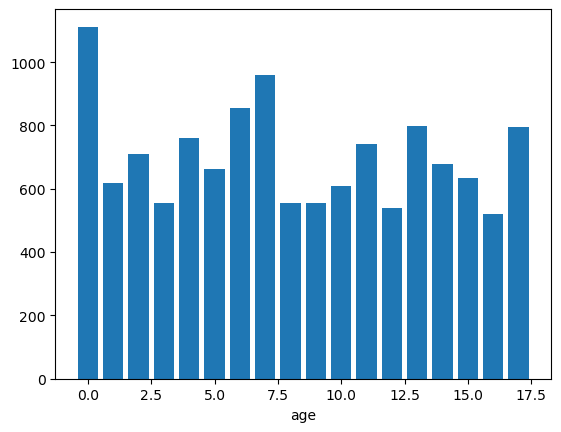

In [72]:
# 인덱스, 눈금 수정 요망
# age_sorted = ['1', '2-3', '4-6', '7-9', '10-12',
#               '13-15', '16-19', '20-24', '25-29', '30-34',
#               '35-39', '40-44', '45-49', '50-54', '55-59',
#               '60-64', '65-69', '70']
# age_dict = {'1': 0, '10-12': 1, '13-15': 2, '16-19': 3, '2-3': 4,
#             '20-24': 5, '25-29': 6, '30-34': 7, '35-39': 8, '4-6': 9,
#             '40-44': 10, '45-49': 11, '50-54': 12, '55-59': 13, '60-64': 14,
#             '65-69': 15, '7-9': 16, '70': 17}

age_list = list(count.keys())
frequencies = list(count.values())

plt.bar(age_list, frequencies)
plt.xlabel('age')
plt.show()

In [73]:
### 1. resnet18
### 1-1. resnet18 / SGD
### 1-2. resnet18 / RMSprop
### 1-3. resnet18 / AdamW
### 2. vgg13
### 3. googlenet

### 1-1-1. resnet18 / SGD(lr=0.010, mo=0.9)

In [74]:
model = myResNet(18, num_classes=18).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.010, momentum=0.9)

In [75]:
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

In [76]:
for epoch in range(1, 21):
    train(model, train_loader, optimizer, epoch)
    test(model, test_loader)

Epoch 1, Training loss: 2.4922, Accuracy: 11.11%
Test loss: 2.2888, Accuracy: 22.92%
Epoch 2, Training loss: 2.0017, Accuracy: 0.00%
Test loss: 2.4672, Accuracy: 18.53%
Epoch 3, Training loss: 1.7180, Accuracy: 22.22%
Test loss: 2.0995, Accuracy: 31.05%
Epoch 4, Training loss: 1.5025, Accuracy: 33.33%
Test loss: 1.9314, Accuracy: 30.94%
Epoch 5, Training loss: 1.2661, Accuracy: 88.89%
Test loss: 2.6340, Accuracy: 27.02%
Epoch 6, Training loss: 1.0370, Accuracy: 33.33%
Test loss: 2.2831, Accuracy: 33.62%
Epoch 7, Training loss: 0.8185, Accuracy: 77.78%
Test loss: 2.4610, Accuracy: 32.91%
Epoch 8, Training loss: 0.5507, Accuracy: 77.78%
Test loss: 2.7109, Accuracy: 36.11%
Epoch 9, Training loss: 0.4557, Accuracy: 77.78%
Test loss: 2.6237, Accuracy: 37.34%
Epoch 10, Training loss: 0.4008, Accuracy: 77.78%
Test loss: 3.3429, Accuracy: 30.82%
Epoch 11, Training loss: 0.2644, Accuracy: 77.78%
Test loss: 2.7852, Accuracy: 36.94%
Epoch 12, Training loss: 0.2010, Accuracy: 88.89%
Test loss: 2.9

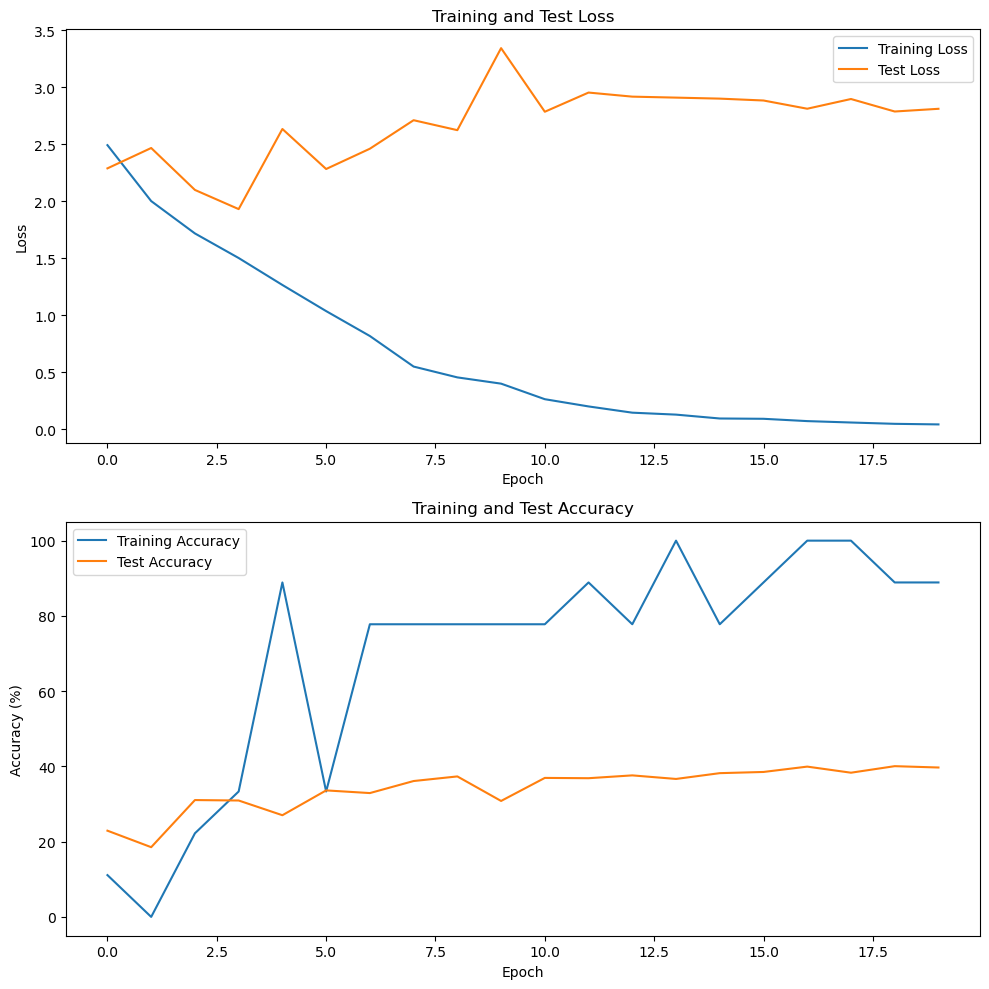

In [77]:
val_plot(train_losses, test_losses, train_accuracies, test_accuracies)

### 1-1-2. resnet18 / SGD(lr=0.010, mo=0.5)

In [78]:
model = myResNet(18, num_classes=18).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.010, momentum=0.5)

In [79]:
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

In [80]:
for epoch in range(1, 21):
    train(model, train_loader, optimizer, epoch)
    test(model, test_loader)

Epoch 1, Training loss: 2.6666, Accuracy: 11.11%
Test loss: 2.4818, Accuracy: 16.16%
Epoch 2, Training loss: 2.2538, Accuracy: 0.00%
Test loss: 2.2998, Accuracy: 16.32%
Epoch 3, Training loss: 2.0207, Accuracy: 22.22%
Test loss: 2.2757, Accuracy: 22.52%
Epoch 4, Training loss: 1.8189, Accuracy: 0.00%
Test loss: 2.2281, Accuracy: 21.81%
Epoch 5, Training loss: 1.6349, Accuracy: 11.11%
Test loss: 2.3684, Accuracy: 21.77%
Epoch 6, Training loss: 1.4435, Accuracy: 55.56%
Test loss: 2.0370, Accuracy: 28.21%
Epoch 7, Training loss: 1.2400, Accuracy: 55.56%
Test loss: 2.0520, Accuracy: 30.74%
Epoch 8, Training loss: 1.0365, Accuracy: 55.56%
Test loss: 2.1141, Accuracy: 32.60%
Epoch 9, Training loss: 0.8384, Accuracy: 33.33%
Test loss: 2.4258, Accuracy: 30.11%
Epoch 10, Training loss: 0.6922, Accuracy: 77.78%
Test loss: 2.3575, Accuracy: 32.12%
Epoch 11, Training loss: 0.4738, Accuracy: 55.56%
Test loss: 3.0489, Accuracy: 28.05%
Epoch 12, Training loss: 0.3492, Accuracy: 88.89%
Test loss: 3.13

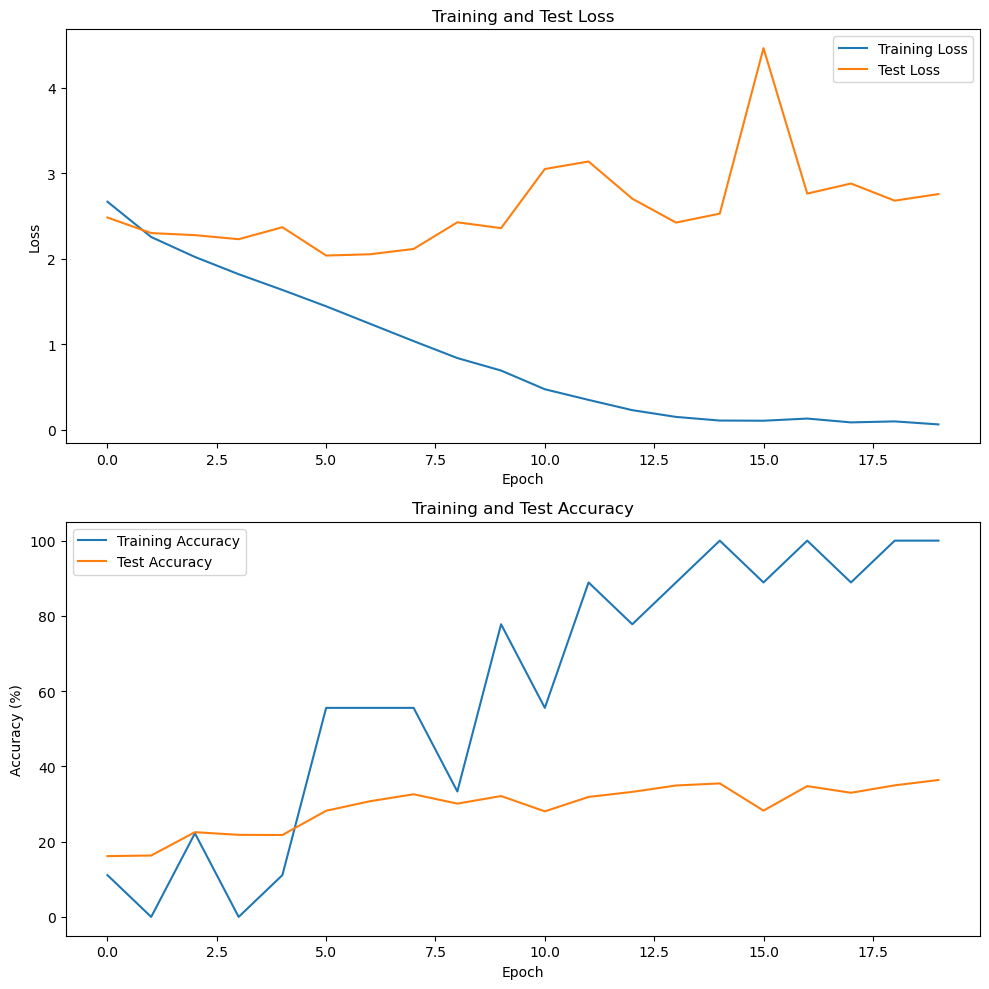

In [81]:
val_plot(train_losses, test_losses, train_accuracies, test_accuracies)

### 1-1-3. resnet18 / SGD(lr=0.010, mo=0.25)

In [82]:
model = myResNet(18, num_classes=18).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.010, momentum=0.25)

In [83]:
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

In [84]:
for epoch in range(1, 21):
    train(model, train_loader, optimizer, epoch)
    test(model, test_loader)

Epoch 1, Training loss: 2.7467, Accuracy: 22.22%
Test loss: 2.7379, Accuracy: 14.62%
Epoch 2, Training loss: 2.4163, Accuracy: 0.00%
Test loss: 2.4969, Accuracy: 14.38%
Epoch 3, Training loss: 2.1633, Accuracy: 22.22%
Test loss: 2.4712, Accuracy: 19.04%
Epoch 4, Training loss: 1.9784, Accuracy: 11.11%
Test loss: 2.1758, Accuracy: 23.55%
Epoch 5, Training loss: 1.8211, Accuracy: 22.22%
Test loss: 2.0153, Accuracy: 26.00%
Epoch 6, Training loss: 1.6572, Accuracy: 66.67%
Test loss: 2.0099, Accuracy: 28.05%
Epoch 7, Training loss: 1.5000, Accuracy: 44.44%
Test loss: 2.1982, Accuracy: 25.13%
Epoch 8, Training loss: 1.3328, Accuracy: 33.33%
Test loss: 2.1452, Accuracy: 26.35%
Epoch 9, Training loss: 1.1427, Accuracy: 77.78%
Test loss: 2.0052, Accuracy: 31.57%
Epoch 10, Training loss: 0.9441, Accuracy: 88.89%
Test loss: 2.0794, Accuracy: 29.44%
Epoch 11, Training loss: 0.7622, Accuracy: 33.33%
Test loss: 2.4501, Accuracy: 29.36%
Epoch 12, Training loss: 0.5972, Accuracy: 44.44%
Test loss: 3.0

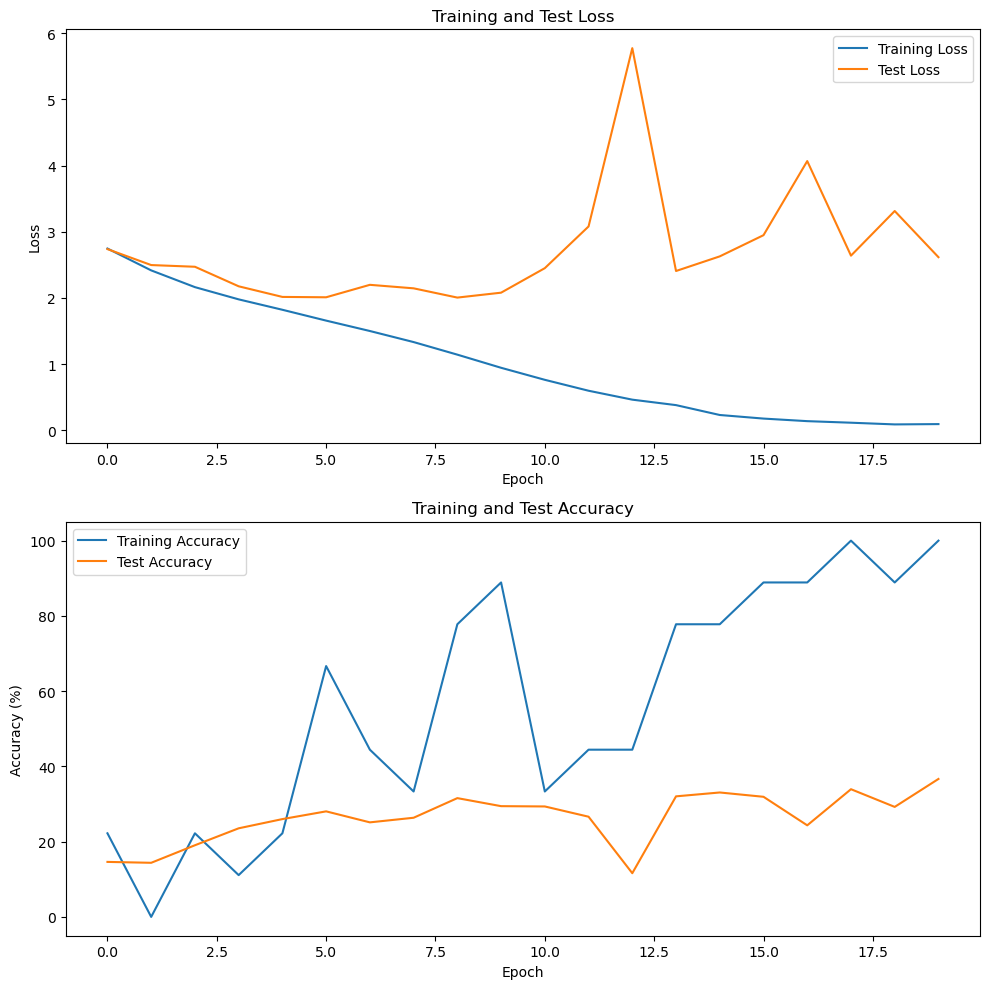

In [85]:
val_plot(train_losses, test_losses, train_accuracies, test_accuracies)

### 1-1-4. resnet18 / SGD(lr=0.005, mo=0.9)

In [86]:
model = myResNet(18, num_classes=18).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.005, momentum=0.9)

In [87]:
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

In [88]:
for epoch in range(1, 21):
    train(model, train_loader, optimizer, epoch)
    test(model, test_loader)

Epoch 1, Training loss: 2.5672, Accuracy: 11.11%
Test loss: 2.4182, Accuracy: 18.93%
Epoch 2, Training loss: 2.0546, Accuracy: 11.11%
Test loss: 2.0889, Accuracy: 27.30%
Epoch 3, Training loss: 1.8012, Accuracy: 11.11%
Test loss: 1.9166, Accuracy: 28.01%
Epoch 4, Training loss: 1.5515, Accuracy: 33.33%
Test loss: 1.9072, Accuracy: 32.36%
Epoch 5, Training loss: 1.2945, Accuracy: 33.33%
Test loss: 1.8757, Accuracy: 32.67%
Epoch 6, Training loss: 1.0748, Accuracy: 66.67%
Test loss: 1.9836, Accuracy: 33.23%
Epoch 7, Training loss: 0.8270, Accuracy: 44.44%
Test loss: 2.1810, Accuracy: 34.57%
Epoch 8, Training loss: 0.6743, Accuracy: 88.89%
Test loss: 2.3144, Accuracy: 35.12%
Epoch 9, Training loss: 0.4062, Accuracy: 66.67%
Test loss: 2.7766, Accuracy: 33.03%
Epoch 10, Training loss: 0.3396, Accuracy: 55.56%
Test loss: 2.8205, Accuracy: 34.37%
Epoch 11, Training loss: 0.2969, Accuracy: 66.67%
Test loss: 2.7786, Accuracy: 36.23%
Epoch 12, Training loss: 0.2666, Accuracy: 66.67%
Test loss: 2.

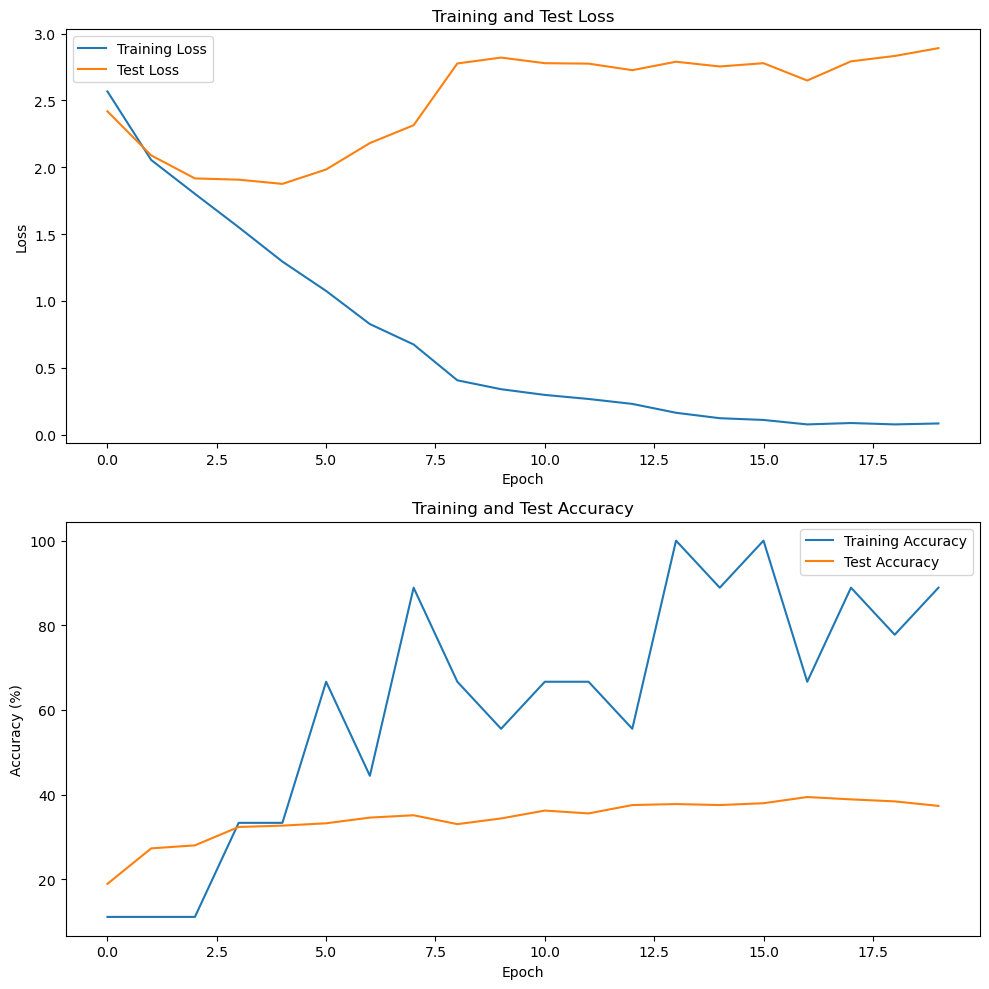

In [89]:
val_plot(train_losses, test_losses, train_accuracies, test_accuracies)

### 1-1-5. resnet18 / SGD(lr=0.005, mo=0.5)

In [90]:
model = myResNet(18, num_classes=18).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.005, momentum=0.5)

In [91]:
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

In [92]:
for epoch in range(1, 21):
    train(model, train_loader, optimizer, epoch)
    test(model, test_loader)

Epoch 1, Training loss: 2.7627, Accuracy: 0.00%
Test loss: 2.6581, Accuracy: 15.69%
Epoch 2, Training loss: 2.4676, Accuracy: 33.33%
Test loss: 2.3889, Accuracy: 18.77%
Epoch 3, Training loss: 2.2505, Accuracy: 22.22%
Test loss: 2.2688, Accuracy: 21.89%
Epoch 4, Training loss: 2.0887, Accuracy: 22.22%
Test loss: 2.1610, Accuracy: 23.63%
Epoch 5, Training loss: 1.9366, Accuracy: 55.56%
Test loss: 2.1218, Accuracy: 23.79%
Epoch 6, Training loss: 1.8043, Accuracy: 33.33%
Test loss: 2.3049, Accuracy: 23.35%
Epoch 7, Training loss: 1.6763, Accuracy: 33.33%
Test loss: 1.9013, Accuracy: 30.54%
Epoch 8, Training loss: 1.5421, Accuracy: 11.11%
Test loss: 1.9443, Accuracy: 28.92%
Epoch 9, Training loss: 1.4033, Accuracy: 33.33%
Test loss: 2.0407, Accuracy: 30.07%
Epoch 10, Training loss: 1.2577, Accuracy: 55.56%
Test loss: 1.9489, Accuracy: 30.86%
Epoch 11, Training loss: 1.0937, Accuracy: 55.56%
Test loss: 1.9320, Accuracy: 31.81%
Epoch 12, Training loss: 0.9310, Accuracy: 55.56%
Test loss: 2.1

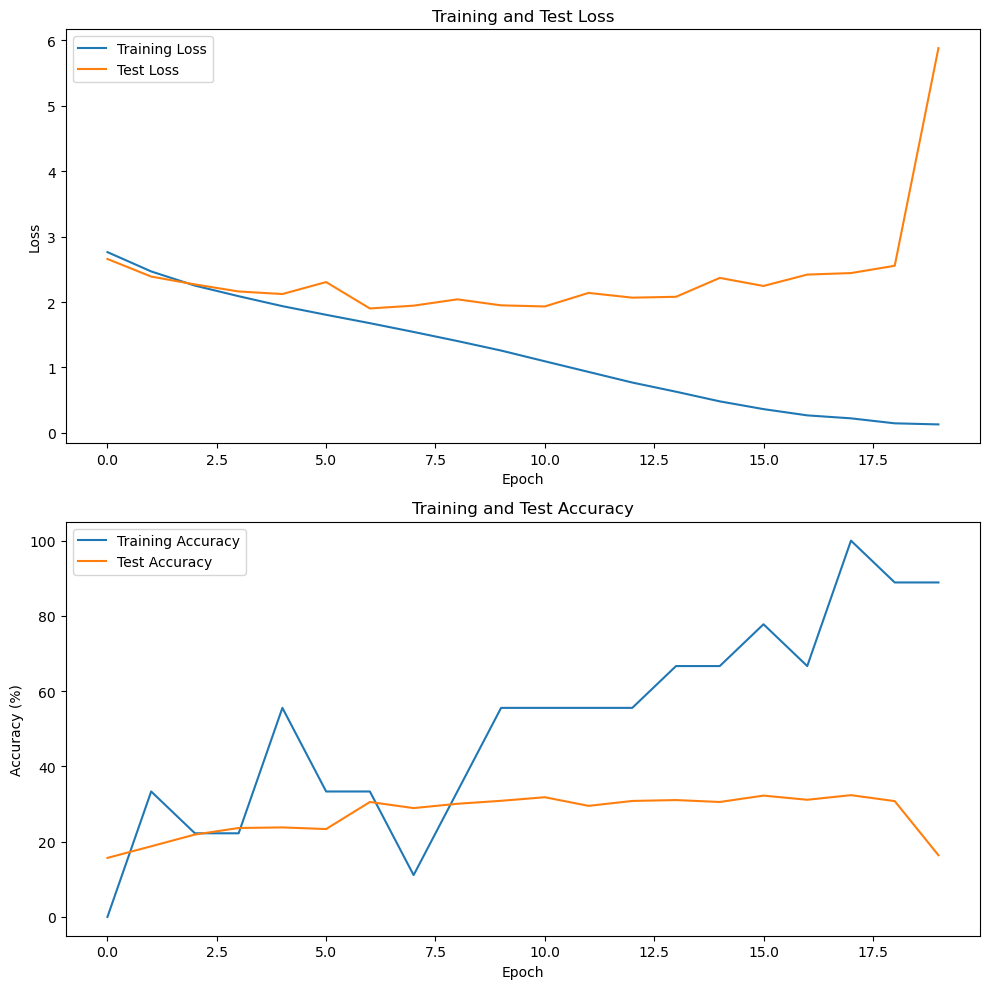

In [93]:
val_plot(train_losses, test_losses, train_accuracies, test_accuracies)

### 1-1-6. resnet18 / SGD(lr=0.005, mo=0.25)

In [94]:
model = myResNet(18, num_classes=18).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.005, momentum=0.25)

In [95]:
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

In [96]:
for epoch in range(1, 21):
    train(model, train_loader, optimizer, epoch)
    test(model, test_loader)

Epoch 1, Training loss: 2.7867, Accuracy: 22.22%
Test loss: 2.6906, Accuracy: 15.57%
Epoch 2, Training loss: 2.5517, Accuracy: 22.22%
Test loss: 2.5118, Accuracy: 18.17%
Epoch 3, Training loss: 2.3726, Accuracy: 11.11%
Test loss: 2.4361, Accuracy: 15.96%
Epoch 4, Training loss: 2.2389, Accuracy: 22.22%
Test loss: 2.2499, Accuracy: 23.11%
Epoch 5, Training loss: 2.1244, Accuracy: 11.11%
Test loss: 2.1619, Accuracy: 24.34%
Epoch 6, Training loss: 2.0164, Accuracy: 0.00%
Test loss: 3.3516, Accuracy: 16.12%
Epoch 7, Training loss: 1.9057, Accuracy: 33.33%
Test loss: 2.1814, Accuracy: 23.47%
Epoch 8, Training loss: 1.8022, Accuracy: 22.22%
Test loss: 2.2515, Accuracy: 23.59%
Epoch 9, Training loss: 1.7068, Accuracy: 22.22%
Test loss: 1.9603, Accuracy: 29.12%
Epoch 10, Training loss: 1.6111, Accuracy: 55.56%
Test loss: 2.0795, Accuracy: 27.14%
Epoch 11, Training loss: 1.5155, Accuracy: 55.56%
Test loss: 2.2597, Accuracy: 25.17%
Epoch 12, Training loss: 1.4132, Accuracy: 11.11%
Test loss: 2.2

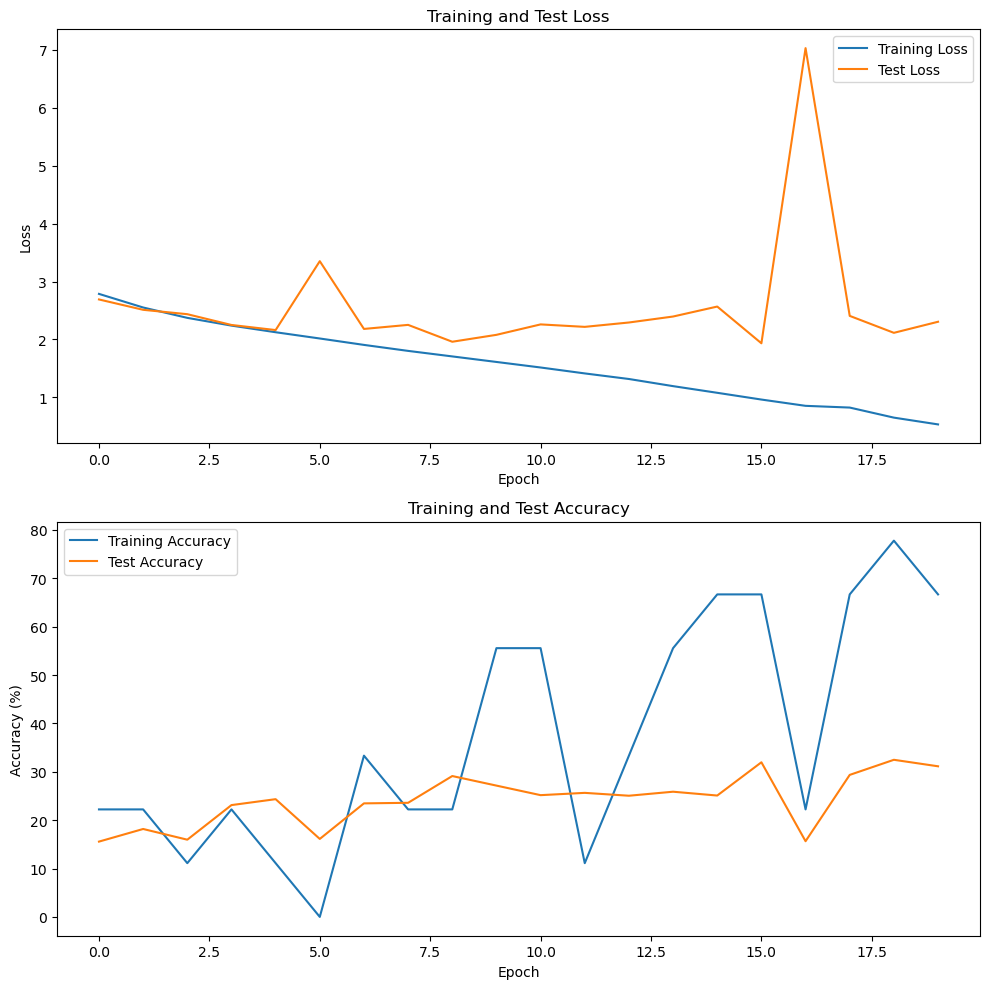

In [97]:
val_plot(train_losses, test_losses, train_accuracies, test_accuracies)

### 1-1-7. resnet18 / SGD(lr=0.001, mo=0.9)

In [98]:
model = myResNet(18, num_classes=18).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [99]:
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

In [100]:
for epoch in range(1, 21):
    train(model, train_loader, optimizer, epoch)
    test(model, test_loader)

Epoch 1, Training loss: 2.7863, Accuracy: 11.11%
Test loss: 2.6506, Accuracy: 16.63%
Epoch 2, Training loss: 2.4806, Accuracy: 33.33%
Test loss: 2.3847, Accuracy: 19.76%
Epoch 3, Training loss: 2.2420, Accuracy: 0.00%
Test loss: 2.2375, Accuracy: 23.82%
Epoch 4, Training loss: 2.0721, Accuracy: 22.22%
Test loss: 2.1007, Accuracy: 26.12%
Epoch 5, Training loss: 1.9207, Accuracy: 33.33%
Test loss: 2.0825, Accuracy: 26.04%
Epoch 6, Training loss: 1.7783, Accuracy: 33.33%
Test loss: 1.9663, Accuracy: 28.61%
Epoch 7, Training loss: 1.6554, Accuracy: 11.11%
Test loss: 1.9859, Accuracy: 28.61%
Epoch 8, Training loss: 1.5194, Accuracy: 66.67%
Test loss: 1.9488, Accuracy: 30.11%
Epoch 9, Training loss: 1.3604, Accuracy: 44.44%
Test loss: 1.8907, Accuracy: 32.16%
Epoch 10, Training loss: 1.2038, Accuracy: 66.67%
Test loss: 1.8565, Accuracy: 33.82%
Epoch 11, Training loss: 1.0487, Accuracy: 66.67%
Test loss: 2.0446, Accuracy: 32.56%
Epoch 12, Training loss: 0.9048, Accuracy: 66.67%
Test loss: 1.9

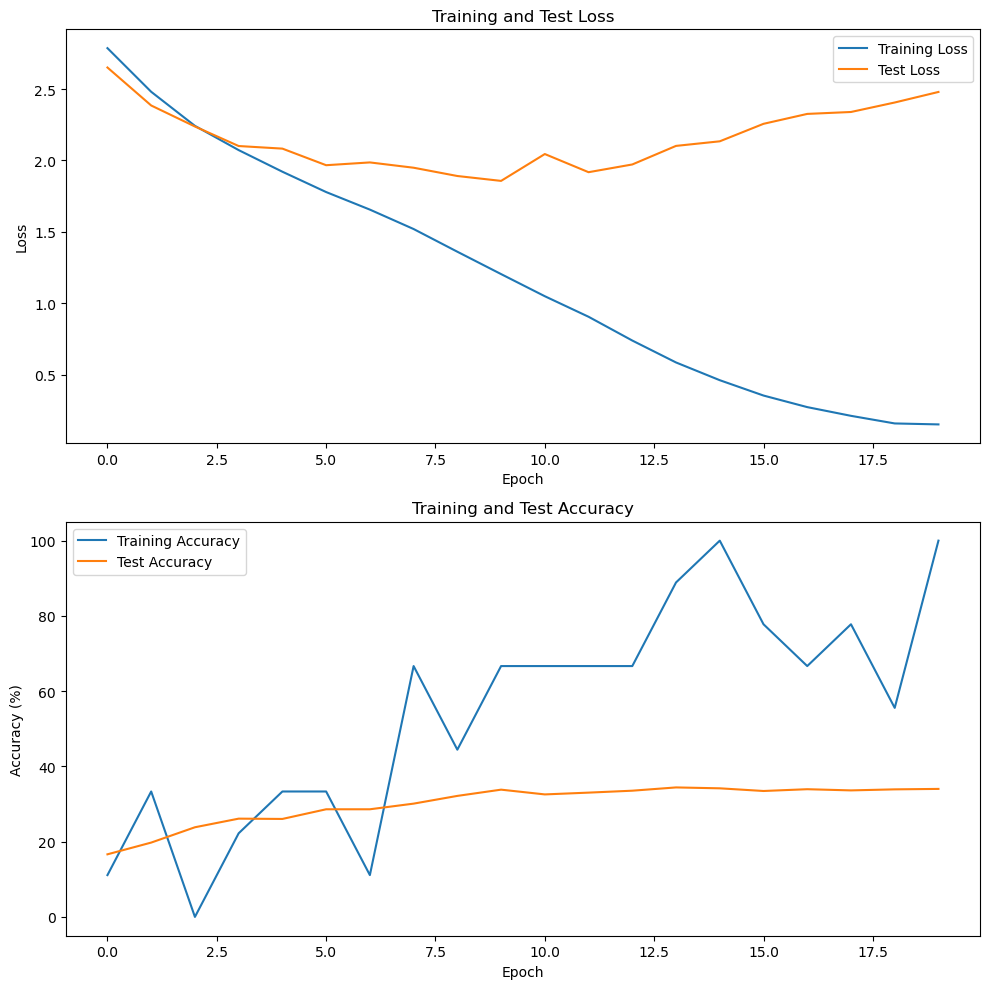

In [101]:
val_plot(train_losses, test_losses, train_accuracies, test_accuracies)

### 1-1-8. resnet18 / SGD(lr=0.001, mo=0.5)

In [102]:
model = myResNet(18, num_classes=18).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.5)

In [103]:
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

In [104]:
for epoch in range(1, 21):
    train(model, train_loader, optimizer, epoch)
    test(model, test_loader)

Epoch 1, Training loss: 2.8623, Accuracy: 22.22%
Test loss: 2.8130, Accuracy: 12.45%
Epoch 2, Training loss: 2.7776, Accuracy: 22.22%
Test loss: 2.7433, Accuracy: 14.90%
Epoch 3, Training loss: 2.7091, Accuracy: 0.00%
Test loss: 2.6863, Accuracy: 16.00%
Epoch 4, Training loss: 2.6382, Accuracy: 11.11%
Test loss: 2.6278, Accuracy: 16.28%
Epoch 5, Training loss: 2.5636, Accuracy: 0.00%
Test loss: 2.5532, Accuracy: 18.37%
Epoch 6, Training loss: 2.4843, Accuracy: 33.33%
Test loss: 2.4788, Accuracy: 19.68%
Epoch 7, Training loss: 2.4092, Accuracy: 22.22%
Test loss: 2.4244, Accuracy: 20.51%
Epoch 8, Training loss: 2.3524, Accuracy: 22.22%
Test loss: 2.3831, Accuracy: 21.69%
Epoch 9, Training loss: 2.2960, Accuracy: 11.11%
Test loss: 2.3376, Accuracy: 22.09%
Epoch 10, Training loss: 2.2487, Accuracy: 33.33%
Test loss: 2.3031, Accuracy: 23.39%
Epoch 11, Training loss: 2.2043, Accuracy: 44.44%
Test loss: 2.2718, Accuracy: 22.36%
Epoch 12, Training loss: 2.1559, Accuracy: 33.33%
Test loss: 2.23

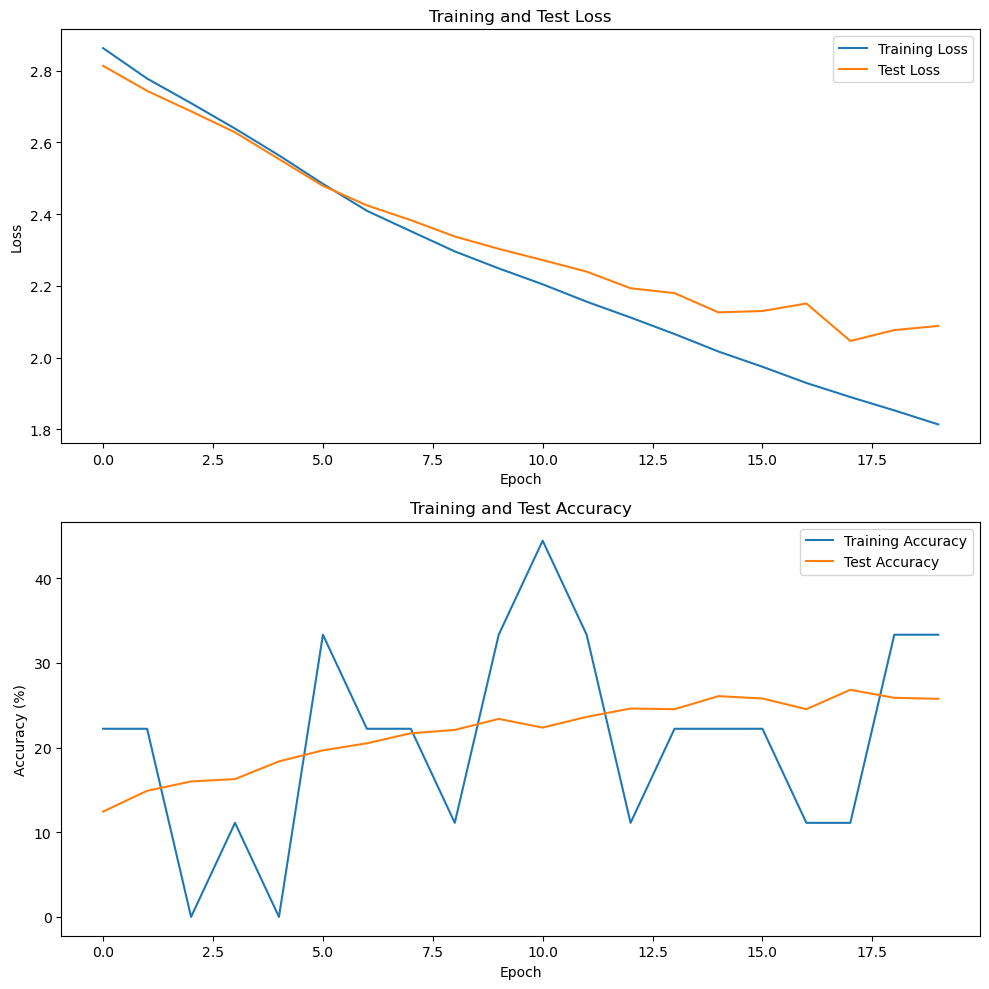

In [105]:
val_plot(train_losses, test_losses, train_accuracies, test_accuracies)

### 1-1-9. resnet18 / SGD(lr=0.001, mo=0.25)

In [106]:
model = myResNet(18, num_classes=18).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.25)

In [107]:
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

In [108]:
for epoch in range(1, 21):
    train(model, train_loader, optimizer, epoch)
    test(model, test_loader)

Epoch 1, Training loss: 2.8855, Accuracy: 22.22%
Test loss: 2.8416, Accuracy: 11.38%
Epoch 2, Training loss: 2.8139, Accuracy: 33.33%
Test loss: 2.8013, Accuracy: 14.18%
Epoch 3, Training loss: 2.7656, Accuracy: 11.11%
Test loss: 2.7549, Accuracy: 14.66%
Epoch 4, Training loss: 2.7214, Accuracy: 11.11%
Test loss: 2.7212, Accuracy: 14.58%
Epoch 5, Training loss: 2.6757, Accuracy: 33.33%
Test loss: 2.6808, Accuracy: 15.65%
Epoch 6, Training loss: 2.6328, Accuracy: 11.11%
Test loss: 2.6506, Accuracy: 17.34%
Epoch 7, Training loss: 2.5857, Accuracy: 11.11%
Test loss: 2.6008, Accuracy: 17.62%
Epoch 8, Training loss: 2.5299, Accuracy: 33.33%
Test loss: 2.5471, Accuracy: 18.10%
Epoch 9, Training loss: 2.4762, Accuracy: 22.22%
Test loss: 2.4982, Accuracy: 19.16%
Epoch 10, Training loss: 2.4184, Accuracy: 22.22%
Test loss: 2.4499, Accuracy: 18.96%
Epoch 11, Training loss: 2.3700, Accuracy: 11.11%
Test loss: 2.4292, Accuracy: 19.83%
Epoch 12, Training loss: 2.3233, Accuracy: 11.11%
Test loss: 2.

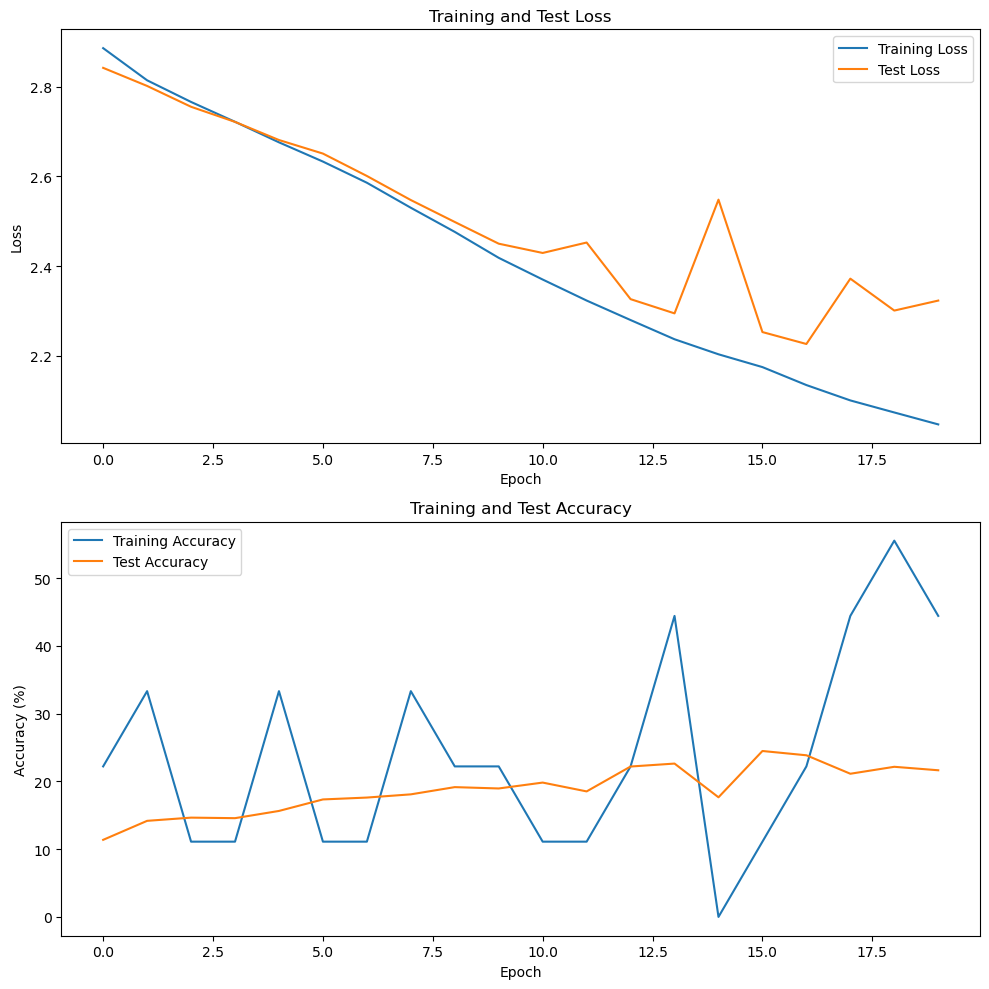

In [109]:
val_plot(train_losses, test_losses, train_accuracies, test_accuracies)

### 1-2-1. resnet18 / RMSprop(lr=0.010, mo=0.9)

In [110]:
model = myResNet(18, num_classes=18).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters(), lr=0.010, momentum=0.9)

In [111]:
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

In [112]:
for epoch in range(1, 21):
    train(model, train_loader, optimizer, epoch)
    test(model, test_loader)

Epoch 1, Training loss: 3.8268, Accuracy: 0.00%
Test loss: 2.7983, Accuracy: 10.00%
Epoch 2, Training loss: 2.7514, Accuracy: 0.00%
Test loss: 2.6501, Accuracy: 15.37%
Epoch 3, Training loss: 2.4101, Accuracy: 22.22%
Test loss: 2.2796, Accuracy: 21.26%
Epoch 4, Training loss: 2.1832, Accuracy: 33.33%
Test loss: 2.0965, Accuracy: 24.30%
Epoch 5, Training loss: 2.0692, Accuracy: 11.11%
Test loss: 2.1851, Accuracy: 24.02%
Epoch 6, Training loss: 1.9664, Accuracy: 66.67%
Test loss: 2.1454, Accuracy: 24.77%
Epoch 7, Training loss: 1.9019, Accuracy: 11.11%
Test loss: 2.0739, Accuracy: 25.29%
Epoch 8, Training loss: 1.8290, Accuracy: 44.44%
Test loss: 1.9293, Accuracy: 29.44%
Epoch 9, Training loss: 1.7565, Accuracy: 55.56%
Test loss: 1.9423, Accuracy: 29.83%
Epoch 10, Training loss: 1.7170, Accuracy: 44.44%
Test loss: 2.0592, Accuracy: 29.71%
Epoch 11, Training loss: 1.6380, Accuracy: 22.22%
Test loss: 1.8992, Accuracy: 29.67%
Epoch 12, Training loss: 1.5708, Accuracy: 22.22%
Test loss: 1.77

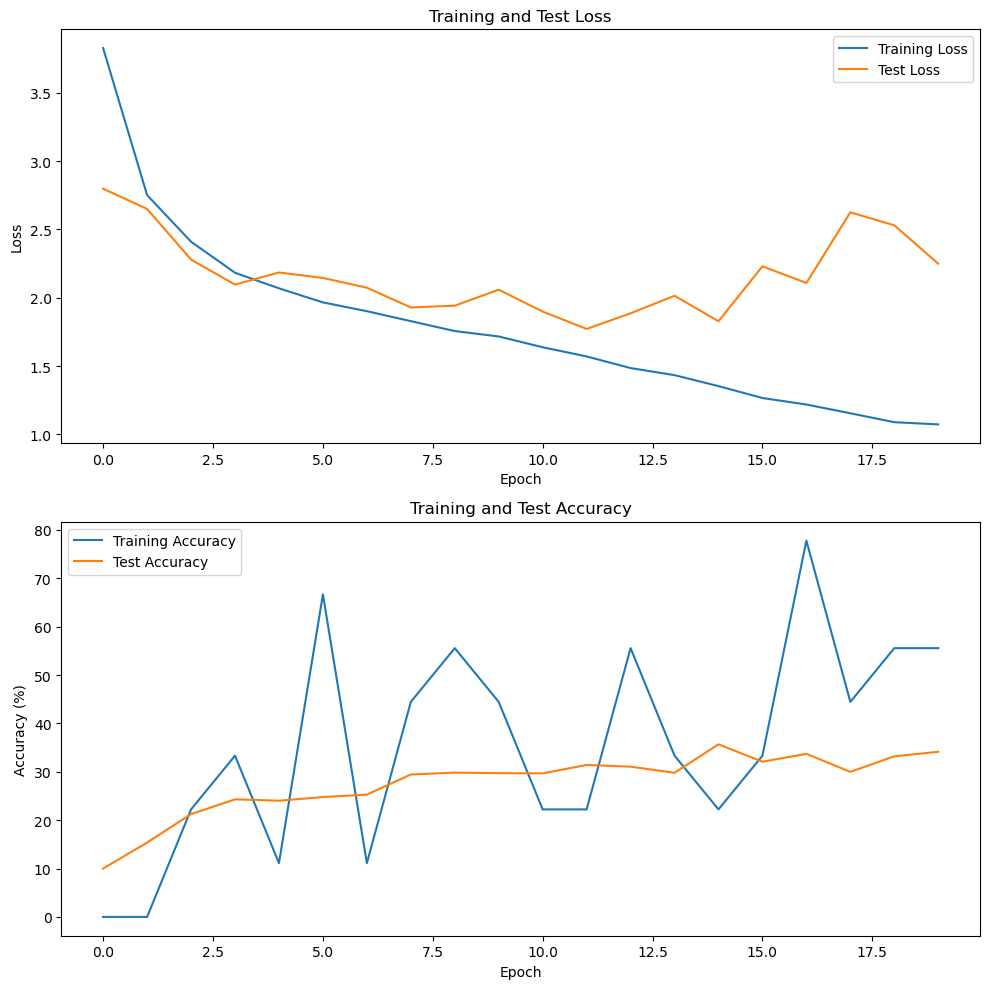

In [113]:
val_plot(train_losses, test_losses, train_accuracies, test_accuracies)

### 1-2-2. resnet18 / RMSprop(lr=0.010, mo=0.5)

In [114]:
model = myResNet(18, num_classes=18).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters(), lr=0.010, momentum=0.5)

In [115]:
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

In [116]:
for epoch in range(1, 21):
    train(model, train_loader, optimizer, epoch)
    test(model, test_loader)

Epoch 1, Training loss: 3.3582, Accuracy: 22.22%
Test loss: 2.8623, Accuracy: 13.24%
Epoch 2, Training loss: 2.5262, Accuracy: 11.11%
Test loss: 2.8806, Accuracy: 13.75%
Epoch 3, Training loss: 2.1824, Accuracy: 44.44%
Test loss: 2.5133, Accuracy: 21.45%
Epoch 4, Training loss: 2.0135, Accuracy: 11.11%
Test loss: 2.7326, Accuracy: 16.91%
Epoch 5, Training loss: 1.8920, Accuracy: 33.33%
Test loss: 2.7408, Accuracy: 21.65%
Epoch 6, Training loss: 1.7815, Accuracy: 22.22%
Test loss: 2.4680, Accuracy: 24.54%
Epoch 7, Training loss: 1.6679, Accuracy: 11.11%
Test loss: 2.1521, Accuracy: 24.54%
Epoch 8, Training loss: 1.5597, Accuracy: 55.56%
Test loss: 1.9472, Accuracy: 31.02%
Epoch 9, Training loss: 1.4419, Accuracy: 33.33%
Test loss: 1.9733, Accuracy: 31.21%
Epoch 10, Training loss: 1.3202, Accuracy: 33.33%
Test loss: 2.2052, Accuracy: 32.08%
Epoch 11, Training loss: 1.1649, Accuracy: 55.56%
Test loss: 2.1364, Accuracy: 31.96%
Epoch 12, Training loss: 0.9914, Accuracy: 55.56%
Test loss: 2.

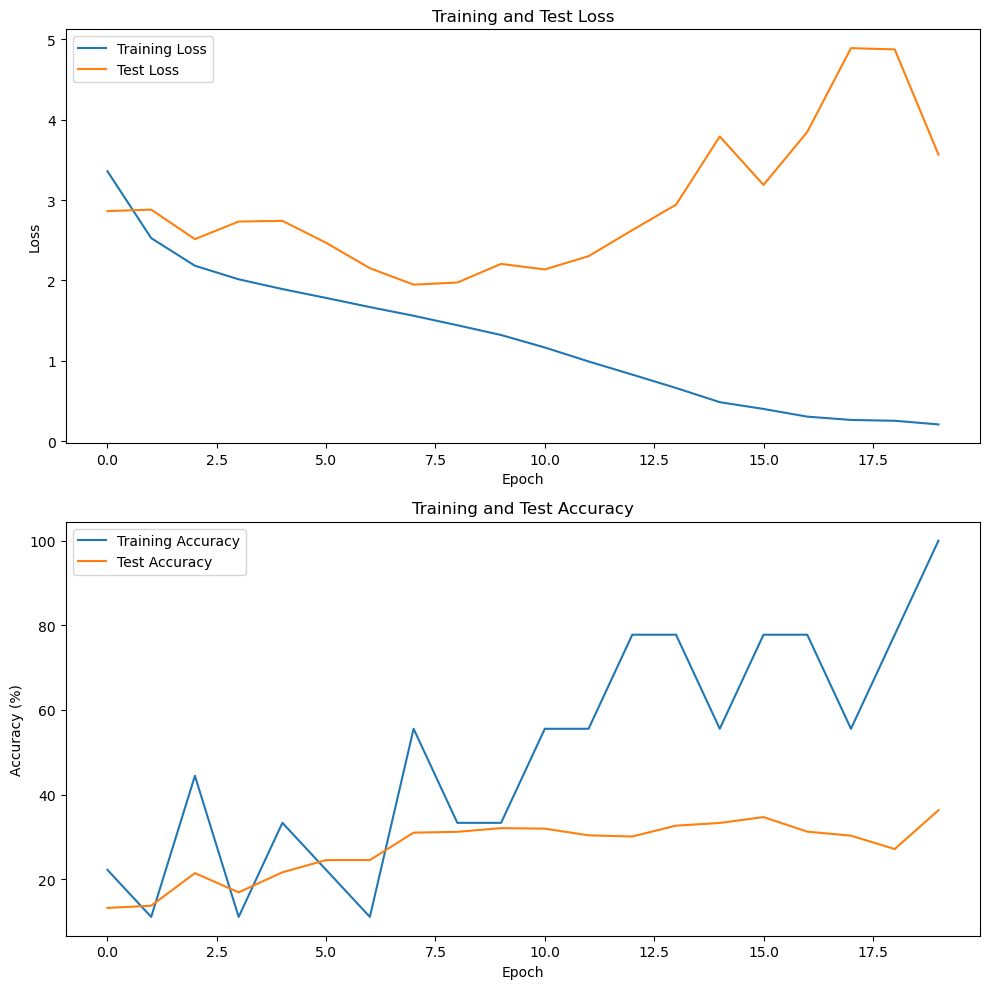

In [117]:
val_plot(train_losses, test_losses, train_accuracies, test_accuracies)

### 1-2-3. resnet18 / RMSprop(lr=0.010, mo=0.25)

In [118]:
model = myResNet(18, num_classes=18).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters(), lr=0.010, momentum=0.25)

In [119]:
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

In [120]:
for epoch in range(1, 21):
    train(model, train_loader, optimizer, epoch)
    test(model, test_loader)

Epoch 1, Training loss: 3.1338, Accuracy: 0.00%
Test loss: 154.7619, Accuracy: 4.39%
Epoch 2, Training loss: 2.5410, Accuracy: 22.22%
Test loss: 2.5012, Accuracy: 17.66%
Epoch 3, Training loss: 2.2176, Accuracy: 11.11%
Test loss: 7.3589, Accuracy: 7.82%
Epoch 4, Training loss: 2.0776, Accuracy: 22.22%
Test loss: 6.6863, Accuracy: 8.26%
Epoch 5, Training loss: 1.9452, Accuracy: 11.11%
Test loss: 3.2878, Accuracy: 14.97%
Epoch 6, Training loss: 1.8254, Accuracy: 55.56%
Test loss: 2.2215, Accuracy: 26.00%
Epoch 7, Training loss: 1.7236, Accuracy: 33.33%
Test loss: 2.5017, Accuracy: 25.84%
Epoch 8, Training loss: 1.6259, Accuracy: 33.33%
Test loss: 2.5650, Accuracy: 22.32%
Epoch 9, Training loss: 1.5144, Accuracy: 44.44%
Test loss: 2.1956, Accuracy: 28.92%
Epoch 10, Training loss: 1.3806, Accuracy: 44.44%
Test loss: 2.0686, Accuracy: 29.55%
Epoch 11, Training loss: 1.2175, Accuracy: 44.44%
Test loss: 2.1690, Accuracy: 33.27%
Epoch 12, Training loss: 1.0197, Accuracy: 66.67%
Test loss: 2.50

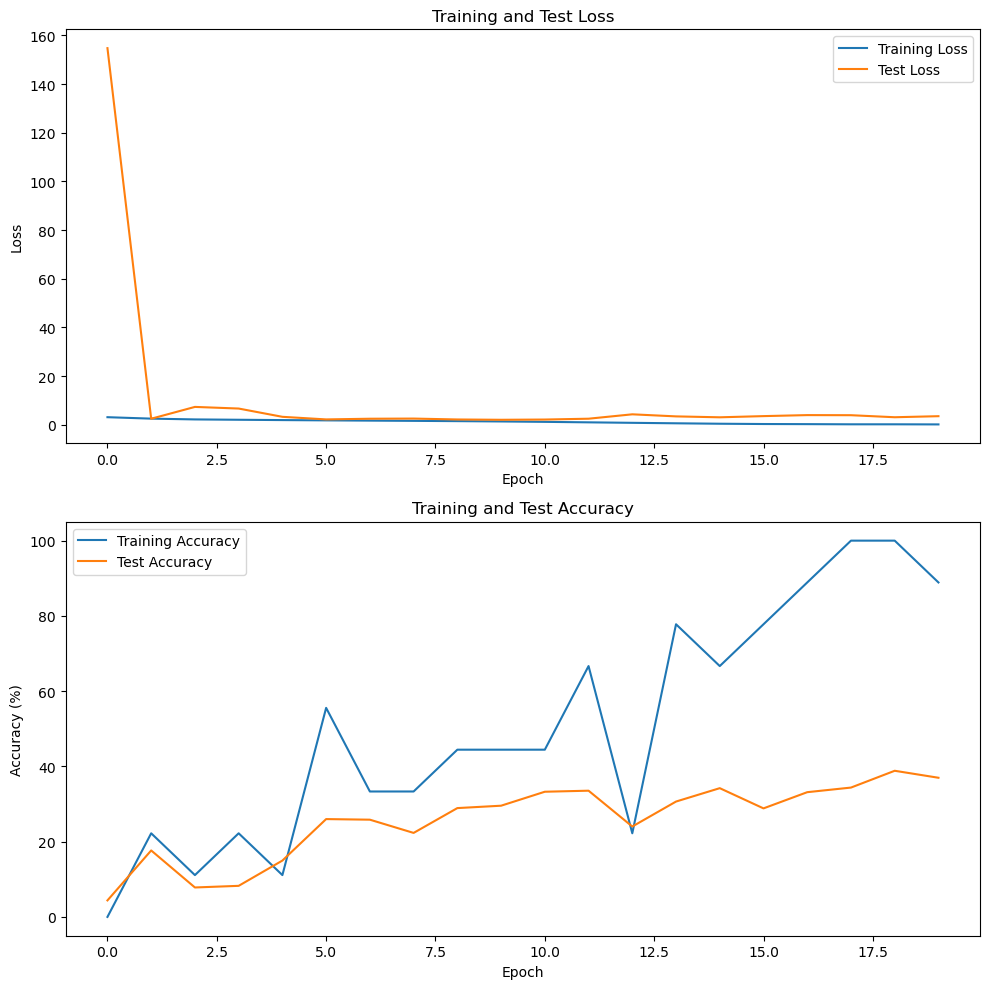

In [121]:
val_plot(train_losses, test_losses, train_accuracies, test_accuracies)

### 1-2-4. resnet18 / RMSprop(lr=0.005, mo=0.9)

In [122]:
model = myResNet(18, num_classes=18).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters(), lr=0.005, momentum=0.9)

In [123]:
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

In [124]:
for epoch in range(1, 21):
    train(model, train_loader, optimizer, epoch)
    test(model, test_loader)

Epoch 1, Training loss: 3.2247, Accuracy: 11.11%
Test loss: 2.8268, Accuracy: 7.15%
Epoch 2, Training loss: 2.6756, Accuracy: 22.22%
Test loss: 2.6369, Accuracy: 16.99%
Epoch 3, Training loss: 2.2809, Accuracy: 11.11%
Test loss: 2.1885, Accuracy: 23.67%
Epoch 4, Training loss: 2.0789, Accuracy: 11.11%
Test loss: 2.1571, Accuracy: 23.03%
Epoch 5, Training loss: 1.9613, Accuracy: 22.22%
Test loss: 2.0828, Accuracy: 22.99%
Epoch 6, Training loss: 1.8527, Accuracy: 66.67%
Test loss: 1.8856, Accuracy: 30.19%
Epoch 7, Training loss: 1.7820, Accuracy: 44.44%
Test loss: 1.9640, Accuracy: 30.46%
Epoch 8, Training loss: 1.6845, Accuracy: 44.44%
Test loss: 1.9459, Accuracy: 30.86%
Epoch 9, Training loss: 1.6206, Accuracy: 33.33%
Test loss: 1.8431, Accuracy: 31.88%
Epoch 10, Training loss: 1.5264, Accuracy: 77.78%
Test loss: 1.9610, Accuracy: 33.11%
Epoch 11, Training loss: 1.4330, Accuracy: 22.22%
Test loss: 1.7242, Accuracy: 35.44%
Epoch 12, Training loss: 1.3386, Accuracy: 33.33%
Test loss: 1.9

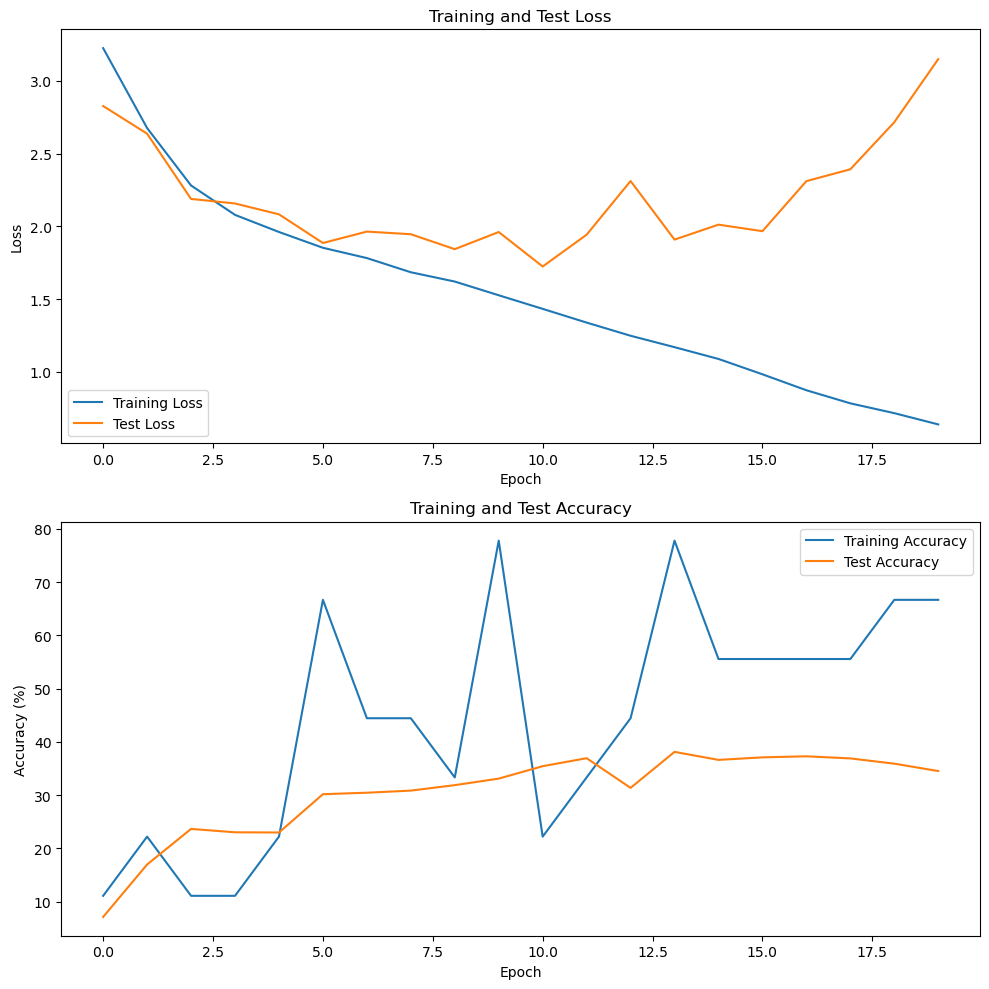

In [125]:
val_plot(train_losses, test_losses, train_accuracies, test_accuracies)

### 1-2-5. resnet18 / RMSprop(lr=0.005, mo=0.5)

In [126]:
model = myResNet(18, num_classes=18).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters(), lr=0.005, momentum=0.5)

In [127]:
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

In [128]:
for epoch in range(1, 21):
    train(model, train_loader, optimizer, epoch)
    test(model, test_loader)

Epoch 1, Training loss: 3.1616, Accuracy: 11.11%
Test loss: 2.5757, Accuracy: 17.03%
Epoch 2, Training loss: 2.3569, Accuracy: 33.33%
Test loss: 2.3328, Accuracy: 21.18%
Epoch 3, Training loss: 2.1614, Accuracy: 44.44%
Test loss: 2.1890, Accuracy: 24.97%
Epoch 4, Training loss: 2.0141, Accuracy: 33.33%
Test loss: 2.5074, Accuracy: 20.35%
Epoch 5, Training loss: 1.8893, Accuracy: 0.00%
Test loss: 2.8824, Accuracy: 17.86%
Epoch 6, Training loss: 1.7845, Accuracy: 33.33%
Test loss: 2.2603, Accuracy: 26.43%
Epoch 7, Training loss: 1.6900, Accuracy: 33.33%
Test loss: 2.3568, Accuracy: 27.06%
Epoch 8, Training loss: 1.5752, Accuracy: 44.44%
Test loss: 2.0650, Accuracy: 28.72%
Epoch 9, Training loss: 1.4647, Accuracy: 44.44%
Test loss: 2.6271, Accuracy: 24.81%
Epoch 10, Training loss: 1.3361, Accuracy: 55.56%
Test loss: 1.7718, Accuracy: 36.11%
Epoch 11, Training loss: 1.1897, Accuracy: 44.44%
Test loss: 2.2753, Accuracy: 30.94%
Epoch 12, Training loss: 1.0233, Accuracy: 33.33%
Test loss: 2.9

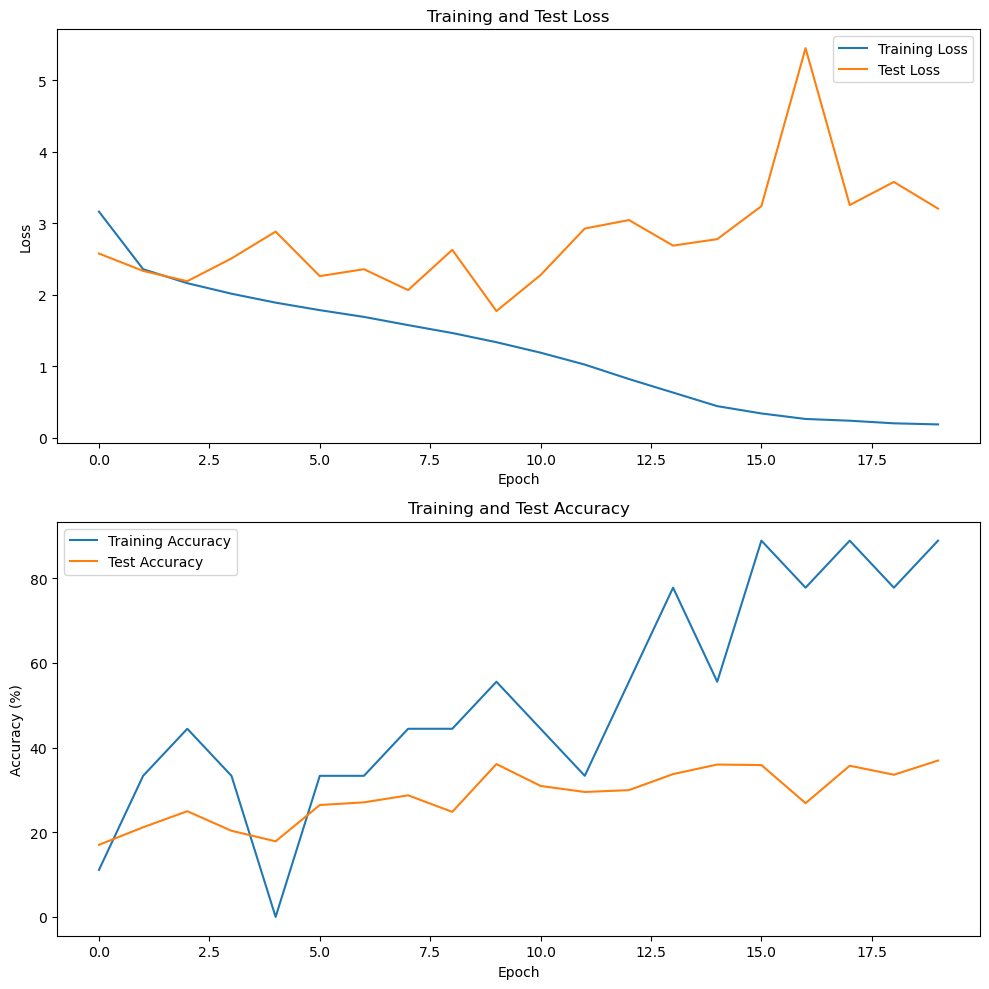

In [129]:
val_plot(train_losses, test_losses, train_accuracies, test_accuracies)

### 1-2-6. resnet18 / RMSprop(lr=0.005, mo=0.25)

In [130]:
model = myResNet(18, num_classes=18).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters(), lr=0.005, momentum=0.25)

In [131]:
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

In [132]:
for epoch in range(1, 21):
    train(model, train_loader, optimizer, epoch)
    test(model, test_loader)

Epoch 1, Training loss: 3.1036, Accuracy: 11.11%
Test loss: 3.2975, Accuracy: 11.26%
Epoch 2, Training loss: 2.3031, Accuracy: 22.22%
Test loss: 2.7007, Accuracy: 16.91%
Epoch 3, Training loss: 2.0621, Accuracy: 22.22%
Test loss: 2.2369, Accuracy: 24.02%
Epoch 4, Training loss: 1.9369, Accuracy: 11.11%
Test loss: 6.5201, Accuracy: 17.11%
Epoch 5, Training loss: 1.8280, Accuracy: 33.33%
Test loss: 3.0014, Accuracy: 17.70%
Epoch 6, Training loss: 1.7324, Accuracy: 11.11%
Test loss: 38.4229, Accuracy: 15.53%
Epoch 7, Training loss: 1.6403, Accuracy: 44.44%
Test loss: 1.8410, Accuracy: 32.00%
Epoch 8, Training loss: 1.5250, Accuracy: 33.33%
Test loss: 2.0689, Accuracy: 28.92%
Epoch 9, Training loss: 1.4105, Accuracy: 33.33%
Test loss: 2.3301, Accuracy: 25.60%
Epoch 10, Training loss: 1.2759, Accuracy: 44.44%
Test loss: 7.7360, Accuracy: 20.55%
Epoch 11, Training loss: 1.1446, Accuracy: 11.11%
Test loss: 4.8060, Accuracy: 16.79%
Epoch 12, Training loss: 0.9958, Accuracy: 44.44%
Test loss: 3

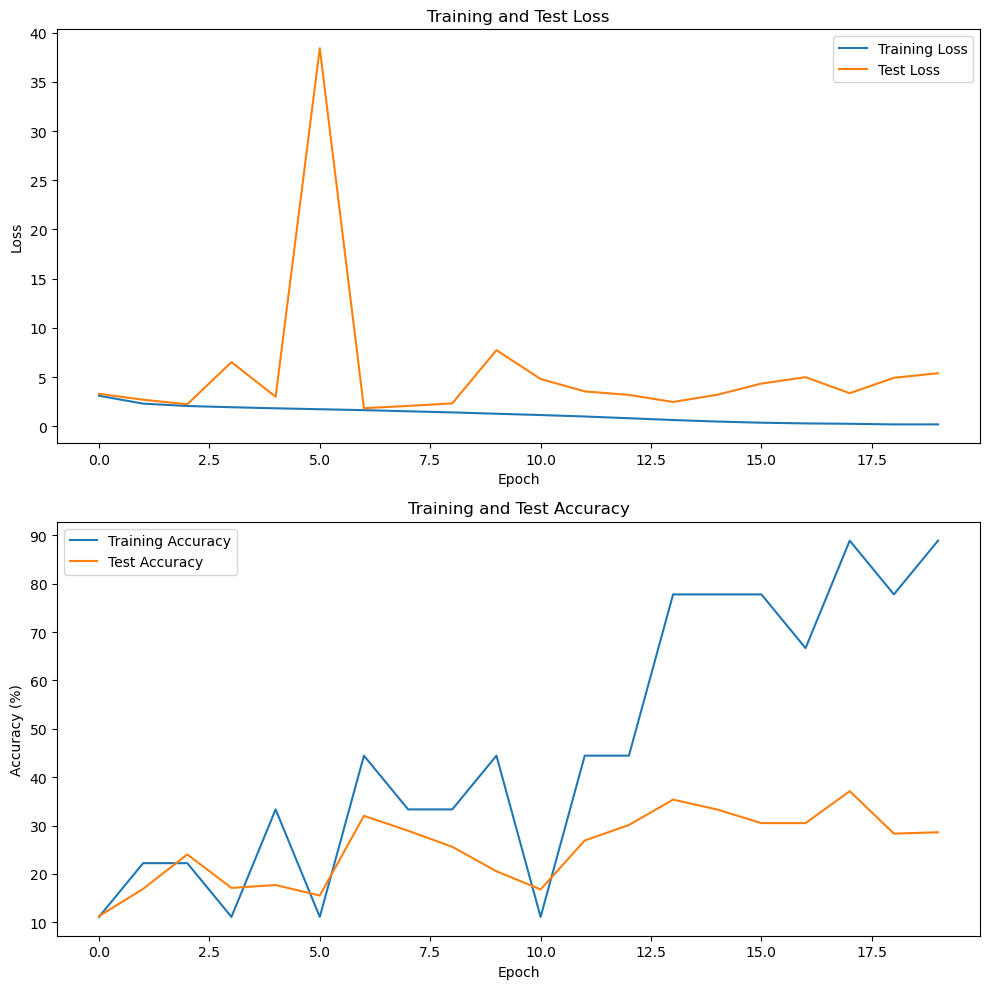

In [133]:
val_plot(train_losses, test_losses, train_accuracies, test_accuracies)

### 1-2-7. resnet18 / RMSprop(lr=0.001, mo=0.9)

In [134]:
model = myResNet(18, num_classes=18).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters(), lr=0.001, momentum=0.9)

In [135]:
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

In [136]:
for epoch in range(1, 21):
    train(model, train_loader, optimizer, epoch)
    test(model, test_loader)

Epoch 1, Training loss: 2.9276, Accuracy: 22.22%
Test loss: 2.8002, Accuracy: 18.33%
Epoch 2, Training loss: 2.3262, Accuracy: 0.00%
Test loss: 2.2670, Accuracy: 19.44%
Epoch 3, Training loss: 2.1532, Accuracy: 11.11%
Test loss: 2.3100, Accuracy: 19.95%
Epoch 4, Training loss: 1.9940, Accuracy: 22.22%
Test loss: 2.0714, Accuracy: 25.44%
Epoch 5, Training loss: 1.8781, Accuracy: 33.33%
Test loss: 1.8597, Accuracy: 30.23%
Epoch 6, Training loss: 1.7714, Accuracy: 0.00%
Test loss: 1.8747, Accuracy: 33.54%
Epoch 7, Training loss: 1.6622, Accuracy: 55.56%
Test loss: 1.8238, Accuracy: 32.52%
Epoch 8, Training loss: 1.5583, Accuracy: 44.44%
Test loss: 1.7494, Accuracy: 34.61%
Epoch 9, Training loss: 1.4423, Accuracy: 66.67%
Test loss: 3.2667, Accuracy: 33.66%
Epoch 10, Training loss: 1.3253, Accuracy: 44.44%
Test loss: 1.7537, Accuracy: 35.64%
Epoch 11, Training loss: 1.1743, Accuracy: 77.78%
Test loss: 1.8992, Accuracy: 35.99%
Epoch 12, Training loss: 1.0109, Accuracy: 55.56%
Test loss: 1.91

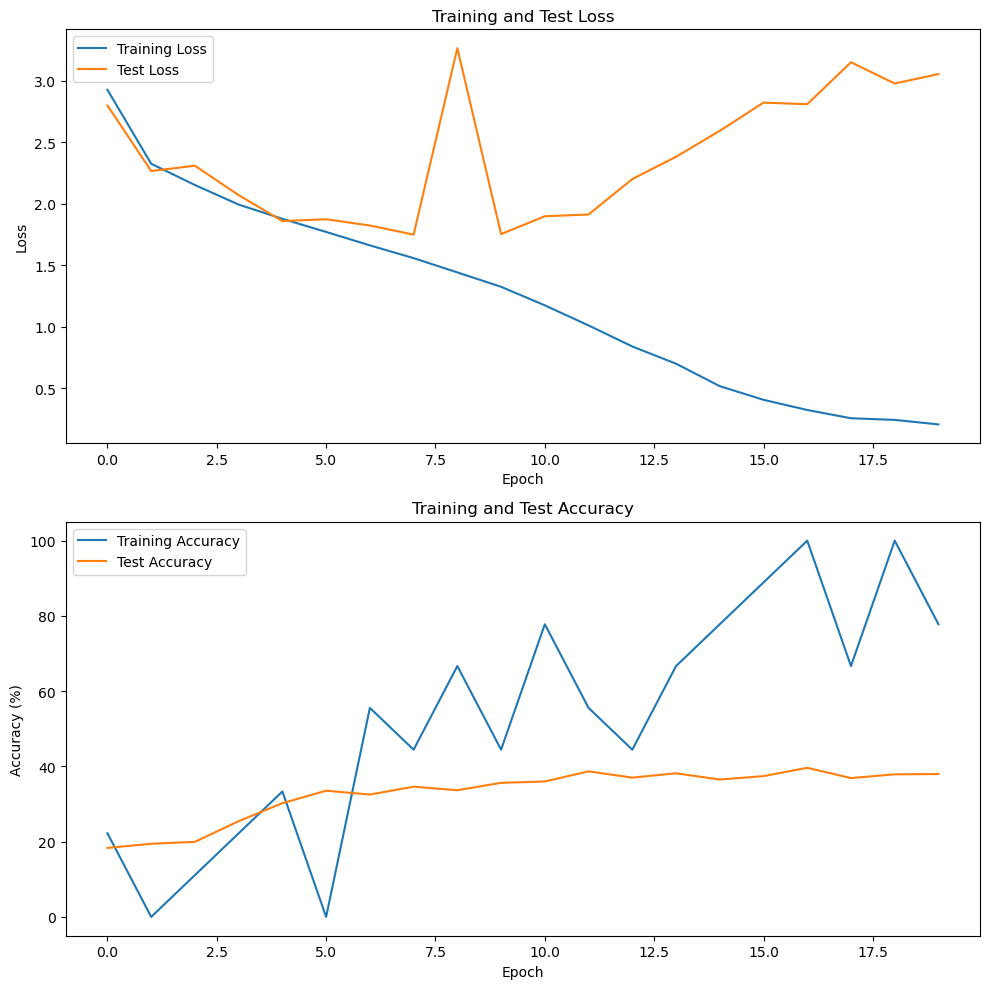

In [137]:
val_plot(train_losses, test_losses, train_accuracies, test_accuracies)

### 1-2-8. resnet18 / RMSprop(lr=0.001, mo=0.5)

In [138]:
model = myResNet(18, num_classes=18).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters(), lr=0.001, momentum=0.5)

In [139]:
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

In [140]:
for epoch in range(1, 21):
    train(model, train_loader, optimizer, epoch)
    test(model, test_loader)

Epoch 1, Training loss: 2.6492, Accuracy: 22.22%
Test loss: 2.5916, Accuracy: 15.37%
Epoch 2, Training loss: 2.1750, Accuracy: 44.44%
Test loss: 2.4108, Accuracy: 22.68%
Epoch 3, Training loss: 1.9672, Accuracy: 11.11%
Test loss: 2.1254, Accuracy: 25.56%
Epoch 4, Training loss: 1.8175, Accuracy: 44.44%
Test loss: 2.3184, Accuracy: 25.60%
Epoch 5, Training loss: 1.7004, Accuracy: 33.33%
Test loss: 1.9628, Accuracy: 29.04%
Epoch 6, Training loss: 1.5872, Accuracy: 33.33%
Test loss: 2.0481, Accuracy: 30.19%
Epoch 7, Training loss: 1.4615, Accuracy: 22.22%
Test loss: 3.0494, Accuracy: 24.50%
Epoch 8, Training loss: 1.3523, Accuracy: 55.56%
Test loss: 2.5083, Accuracy: 28.33%
Epoch 9, Training loss: 1.2513, Accuracy: 44.44%
Test loss: 2.0768, Accuracy: 33.43%
Epoch 10, Training loss: 1.1362, Accuracy: 33.33%
Test loss: 2.5022, Accuracy: 32.12%
Epoch 11, Training loss: 1.0321, Accuracy: 22.22%
Test loss: 2.4798, Accuracy: 30.58%
Epoch 12, Training loss: 0.8773, Accuracy: 66.67%
Test loss: 2.

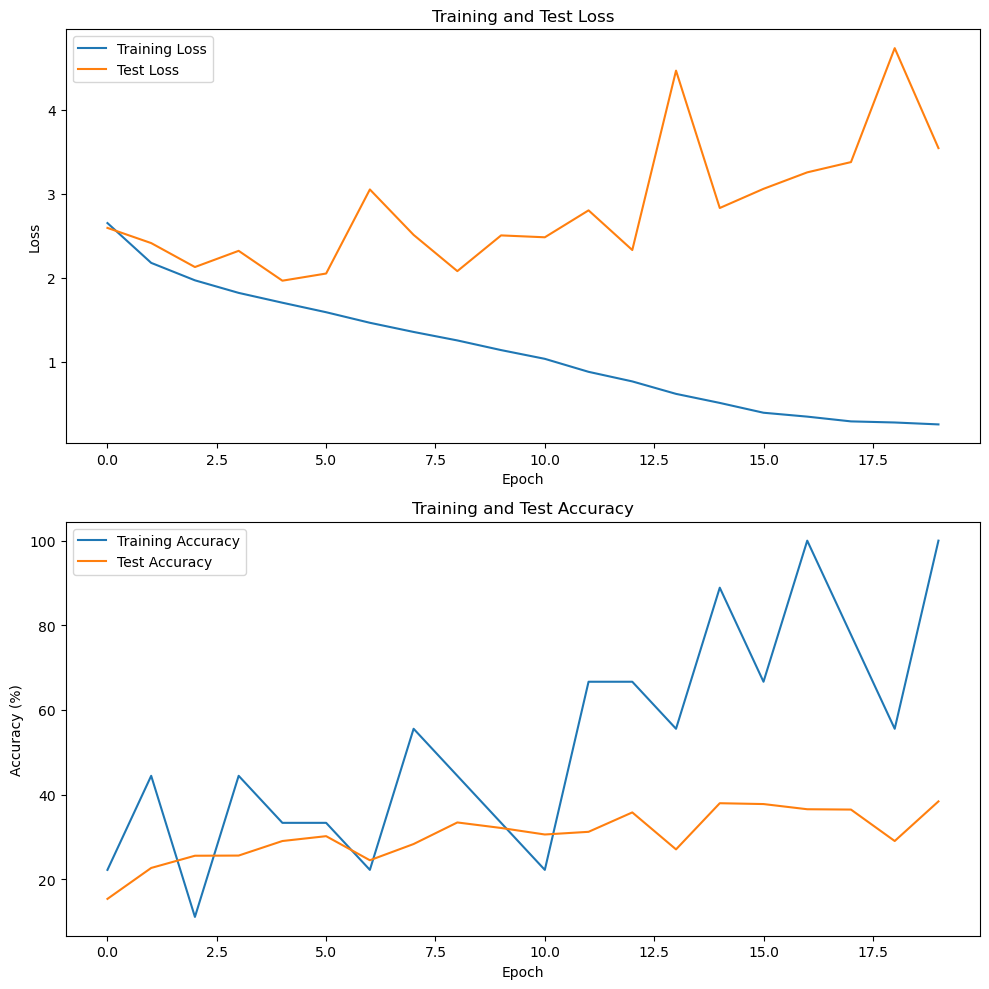

In [141]:
val_plot(train_losses, test_losses, train_accuracies, test_accuracies)

### 1-2-9. resnet18 / RMSprop(lr=0.001, mo=0.25)

In [142]:
model = myResNet(18, num_classes=18).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters(), lr=0.001, momentum=0.25)

In [143]:
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

In [144]:
for epoch in range(1, 21):
    train(model, train_loader, optimizer, epoch)
    test(model, test_loader)

Epoch 1, Training loss: 2.6720, Accuracy: 22.22%
Test loss: 2.7913, Accuracy: 17.03%
Epoch 2, Training loss: 2.1922, Accuracy: 11.11%
Test loss: 2.6109, Accuracy: 13.91%
Epoch 3, Training loss: 1.9678, Accuracy: 11.11%
Test loss: 3.6914, Accuracy: 15.57%
Epoch 4, Training loss: 1.8256, Accuracy: 22.22%
Test loss: 4.9557, Accuracy: 17.82%
Epoch 5, Training loss: 1.6999, Accuracy: 33.33%
Test loss: 3.0247, Accuracy: 23.19%
Epoch 6, Training loss: 1.5804, Accuracy: 66.67%
Test loss: 2.4620, Accuracy: 25.96%
Epoch 7, Training loss: 1.4627, Accuracy: 33.33%
Test loss: 2.4235, Accuracy: 29.87%
Epoch 8, Training loss: 1.3395, Accuracy: 55.56%
Test loss: 2.1144, Accuracy: 29.63%
Epoch 9, Training loss: 1.2162, Accuracy: 44.44%
Test loss: 2.7572, Accuracy: 25.88%
Epoch 10, Training loss: 1.1021, Accuracy: 77.78%
Test loss: 2.2185, Accuracy: 32.44%
Epoch 11, Training loss: 0.9452, Accuracy: 55.56%
Test loss: 2.2668, Accuracy: 32.36%
Epoch 12, Training loss: 0.7996, Accuracy: 77.78%
Test loss: 2.

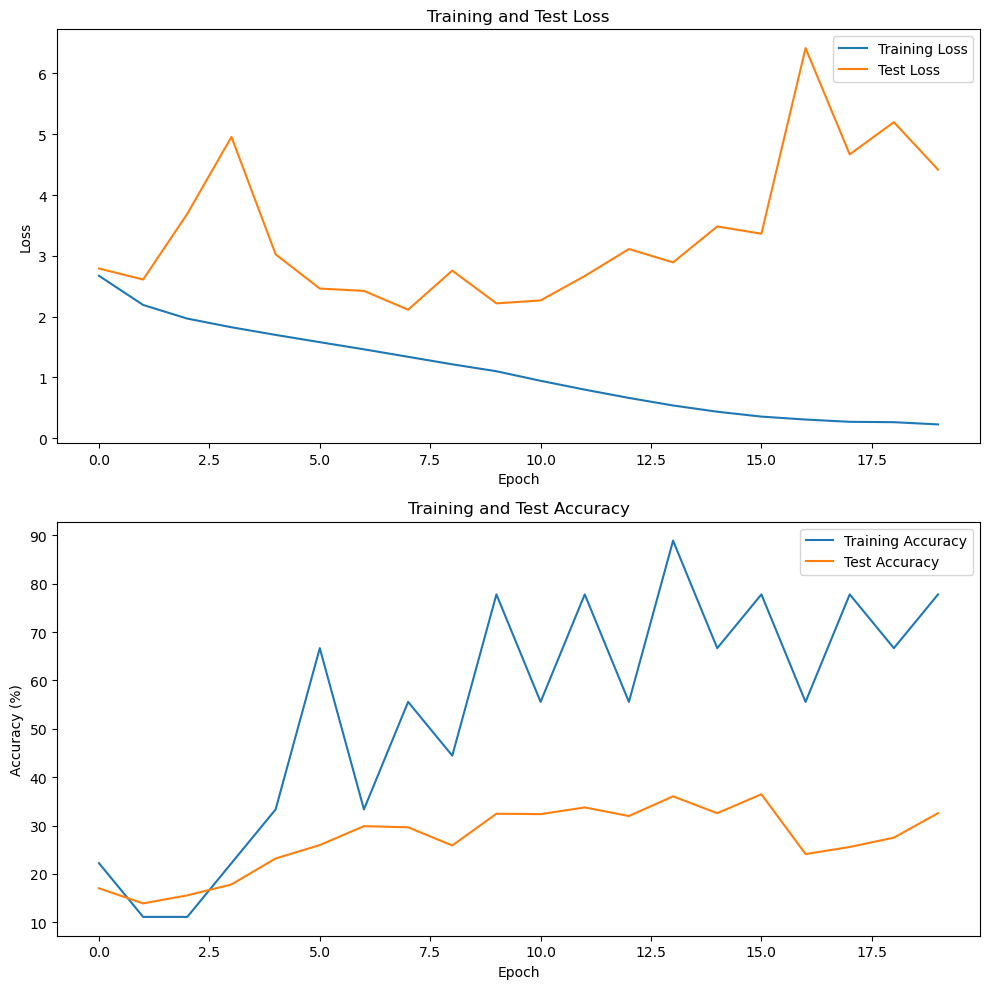

In [145]:
val_plot(train_losses, test_losses, train_accuracies, test_accuracies)